## Importing All the Needed Libraries

In [1]:
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import nltk

import numpy as np

nltk.download('punkt')
nltk.download('stopwords');

[nltk_data] Downloading package punkt to /home/alex/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/alex/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Loading the Data

In [2]:
url = "https://raw.githubusercontent.com/ShishckovA/review-classifier/master/reviews.tsv"
reviews_data = pd.read_csv(url, sep = "\t")
reviews_data.columns = ["review", "liked"]
reviews_data.head()

,review,liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


## Preprate the Data

In [3]:
stop_words = set(stopwords.words("english"))
stop_words.remove("not")
stop_words.remove("no")

def clean_review(review):
    review = re.sub("[^A-Za-z]", " ", review)
    review = review.lower()
    stemmer = PorterStemmer()
    review = [stemmer.stem(word) for word in word_tokenize(review) if (word not in stop_words)]
    review = " ".join(review)
    return review

In [4]:
review = reviews_data.review[0]
print(review)

cleaned_review = clean_review(review)
print(cleaned_review)

Wow... Loved this place.
wow love place


In [5]:
corpus = []
for i in range(0, len(reviews_data)):
    review = clean_review(reviews_data.review[i])
    corpus.append(review)

corpus = np.array(corpus)
corpus[:5]

array(['wow love place', 'crust not good', 'not tasti textur nasti',
       'stop late may bank holiday rick steve recommend love',
       'select menu great price'], dtype='<U106')

## Splitting data for learning

In [6]:
X = corpus
y = reviews_data["liked"].values
X.shape

(1000,)

In [7]:
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te, idx_tr, idx_te = train_test_split(X, y, np.arange(X.shape[0]), random_state=42)
X_tr.shape, y_tr.shape

((750,), (750,))

## Setting up a pipeline of Tf-idf vectorizer and Gradient boosting classifier

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold

clf = Pipeline([("vectorizer", TfidfVectorizer()), ("boosting", GradientBoostingClassifier(random_state=42))])

grid = GridSearchCV(clf, param_grid={
    "boosting__loss": ["deviance", "exponential"], 
    "boosting__learning_rate": np.exp(np.arange(-2, 1)),
    "boosting__n_estimators": [200, 230, 250, 280, 300]
}, scoring="roc_auc", verbose=3, n_jobs=-1, cv=KFold(shuffle=True, random_state=43))

grid.fit(X_tr, y_tr)

print("Best parameters:", grid.best_params_)
print(" Best cv-sciore: {:.2f}".format(grid.best_score_))

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   17.6s finished


Best parameters: {'boosting__learning_rate': 0.1353352832366127, 'boosting__loss': 'deviance', 'boosting__n_estimators': 250}
 Best cv-sciore: 0.88


## Evaluating model on different metrics and examples

 Roc_auc: 0.831
Accuracy: 0.732


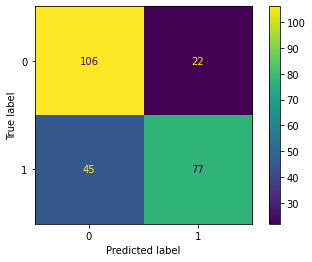

In [9]:
from sklearn.metrics import plot_confusion_matrix, roc_auc_score, accuracy_score

my_roc_auc = roc_auc_score(y_te, grid.predict_proba(X_te)[:, 1])
my_accuracy = accuracy_score(y_te, grid.predict(X_te))
print(" Roc_auc: {:.3f}".format(my_roc_auc))
print("Accuracy: {:.3f}".format(my_accuracy))
plot_confusion_matrix(grid, X_te, y_te);

In [10]:
bad_predicts = (y_te != grid.predict(X_te))
X_raw = reviews_data["review"].values
bad_st_id = idx_te[bad_predicts][:10]
for text, true, text_clean in zip(X_raw[bad_st_id], y[bad_st_id], corpus[bad_st_id]):
    print(true, text, text_clean)

1 If you haven't gone here GO NOW! gone go
1 Come hungry, leave happy and stuffed! come hungri leav happi stuf
1 I had a seriously solid breakfast here. serious solid breakfast
0 The food wasn't good. food good
1 I went to Bachi Burger on a friend's recommendation and was not disappointed. went bachi burger friend recommend not disappoint
1 My boyfriend and I came here for the first time on a recent trip to Vegas and could not have been more pleased with the quality of food and service. boyfriend came first time recent trip vega could not pleas qualiti food servic
0 If that bug never showed up I would have given a 4 for sure, but on the other side of the wall where this bug was climbing was the kitchen. bug never show would given sure side wall bug climb kitchen
0 The Buffet at Bellagio was far from what I anticipated. buffet bellagio far anticip
0 I was VERY disappointed!! disappoint
1 This place is like Chipotle, but BETTER. place like chipotl better


In [11]:
feature_imps = grid.best_estimator_["boosting"].feature_importances_
res = feature_imps.argsort()[::-1]
np.array(grid.best_estimator_["vectorizer"].get_feature_names())[res][:20]

array(['great', 'not', 'good', 'delici', 'love', 'amaz', 'nice',
       'restaur', 'friendli', 'awesom', 'excel', 'disappoint', 'enjoy',
       'perfect', 'fantast', 'bad', 'best', 'no', 'fun', 'everi'],
      dtype='<U17')

In [12]:
grid.predict([
    clean_review("Wery tasty!"),
    clean_review("Not wery tasty."),
    clean_review("Disappointed a lot")
])

array([1, 0, 0])